# Text Analysis of Sentiments using LSTM Bidirectional Model

## Importing all the necessary library

In [1]:
import pandas as pd
import os
import numpy as np
from numpy import asarray
from numpy import zeros

import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# from nltk.stem import PorterStemmer
# from nltk.stem import SnowballStemmer
# nltk.download("stopwords") download if package not installed already
# nltk.download('wordnet')


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.layers.core import Activation, Dropout, Dense
from keras.metrics import Precision, Recall
from keras.optimizers import RMSprop
from keras.models import load_model

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras import losses

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import re
import string
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)

# Setting the working directory

##### Set the directory Here Before loading the data set

In [2]:
os.chdir("D:/LSTM Data")
current_directory = os.getcwd()
print(current_directory)

D:\LSTM Data


# Reading the data

In [3]:
df = pd.read_csv("Twitter_Data.csv")
df.head()

clean_text  \
0    when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples   
1                                                                                                                                                  talk all the nonsense and continue all the drama will vote for modi    
2                                                                                                 what did just say vote for modi  welcome bjp told you rahul the main campaigner for modi think modi should just relax   
3  asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming from chowkidars   
4                                                                                                                                     answer who among these the most powerful world leader today trump putin modi may    

   category  
0      -1.0  
1       0.0  
2       1.0  
3       1.0  
4       1.0

In [4]:
df['category'] = df['category'].map({-1: -1.0, 0: 0.0, 1:1.0})
df = df.rename(columns={'clean_text':'Text_Data' , 'category':'Sentiments'})
df.head()

Text_Data  \
0    when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples   
1                                                                                                                                                  talk all the nonsense and continue all the drama will vote for modi    
2                                                                                                 what did just say vote for modi  welcome bjp told you rahul the main campaigner for modi think modi should just relax   
3  asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming from chowkidars   
4                                                                                                                                     answer who among these the most powerful world leader today trump putin modi may    

   Sentiments  
0        -1.0  
1         0.0  
2         1.0  
3         1.0  
4         1.0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Text_Data   162976 non-null  object 
 1   Sentiments  162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [6]:
df.shape

(162980, 2)

# Target Column is Sentiments

In [7]:
df['Sentiments'].unique()

array([-1.,  0.,  1., nan])

# Checking null values

In [8]:
df.isnull().sum()

Text_Data     4
Sentiments    7
dtype: int64

In [9]:
df = df.dropna()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Text_Data   162969 non-null  object 
 1   Sentiments  162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


In [11]:
df.iloc[258]

Text_Data     there are two possibilities here\n1as you said managing\n2no substantial evidences against got bail\neven the first case got bail when are togetherso can manage its very clear choice urs 
Sentiments                                                                                                                                                                                            1.0
Name: 259, dtype: object

# Text Cleaning and Preprocessing

### Will be using stopwords, regex, lemmatization to clean the texts

In [12]:
eng_stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def cleaning(sen, lem=True):
    sen = re.sub(r'\d+', '', sen)
    sen = re.sub(regex, ' ', str(sen).lower()).strip()
    sen_list = []
    for token in sen.split():
        if token not in eng_stopwords:
            if lem:
                sen_list.append(lemmatizer.lemmatize(token))
            else:
                sen_list.append(token)
    return " ".join(sen_list)

In [13]:
X = []
sentences = list(df['Text_Data'])
for sen in sentences:
    X.append(cleaning(sen))


In [14]:
X[384]

'rajasthan governor kalyan singh aligarh rd march bjp worker want bjp emerge victorious want modi become'

## Creating dummy Variables for sentiments column

In [15]:
y = pd.get_dummies(df['Sentiments'])
y.shape

(162969, 3)

# Exploratory Data Analysis

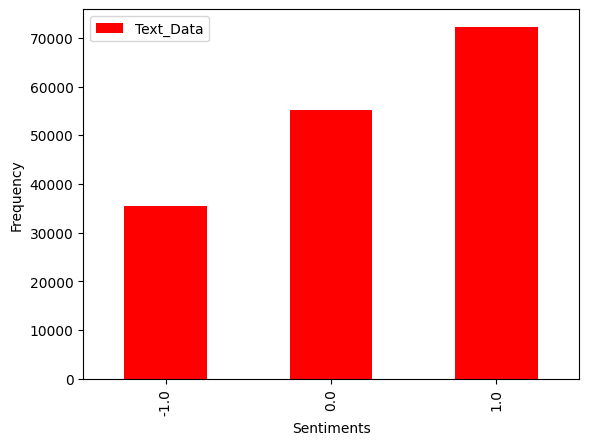

In [16]:
df.groupby('Sentiments').count().plot(kind='bar', color='red')
plt.ylabel("Frequency")
plt.show()

In [17]:
df['Text_Data'].describe()

count                                                                                                                                                                                                                 162969
unique                                                                                                                                                                                                                162969
top       when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
freq                                                                                                                                                                                                                       1
Name: Text_Data, dtype: object

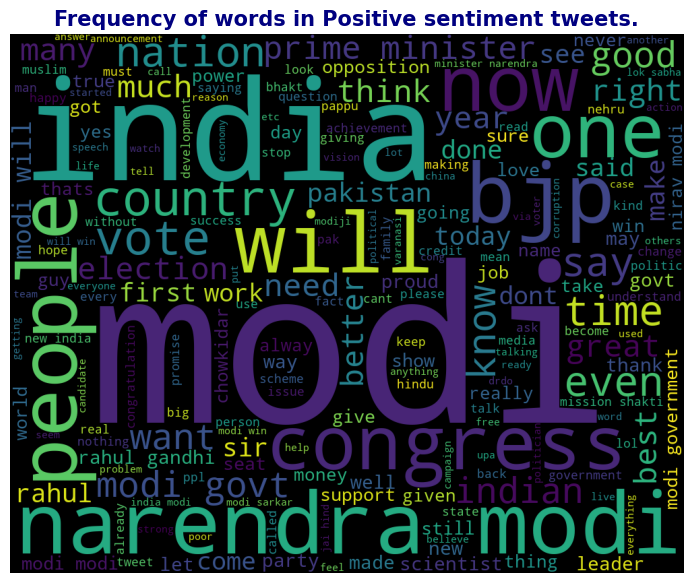

In [18]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, width=1000, height=800, background_color="black").generate(" ".join(df[df['Sentiments']== 1].Text_Data))
plt.imshow(word_cloud)
plt.axis('off')
plt.title('Frequency of words in Positive sentiment tweets.',fontsize=15, fontweight='bold', color='navy')
plt.show()

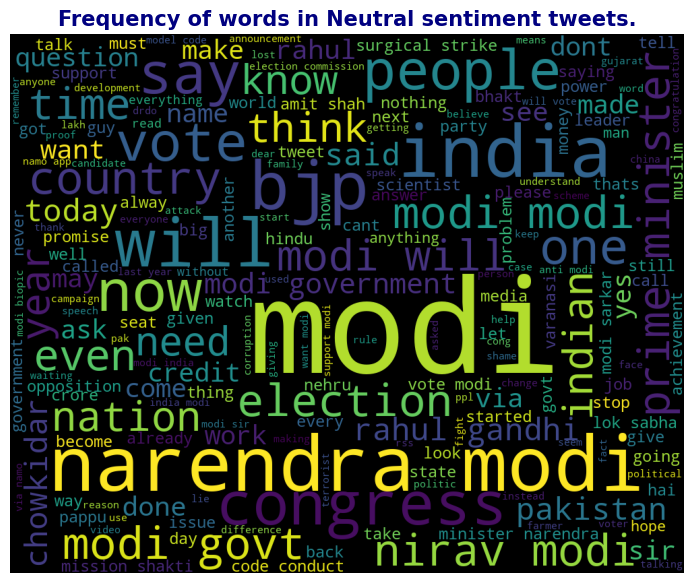

In [19]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, width=1000, height=800, background_color="black").generate(" ".join(df[df['Sentiments']== 0].Text_Data))
plt.imshow(word_cloud)
plt.axis('off')
plt.title('Frequency of words in Neutral sentiment tweets.',fontsize=15, fontweight='bold', color='navy')
plt.show()

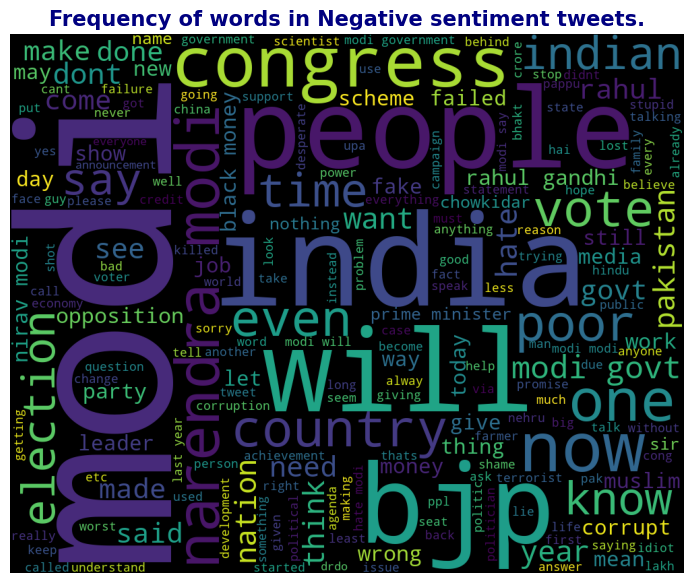

In [20]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, width=1000, height=800, background_color="black").generate(" ".join(df[df['Sentiments']== -1].Text_Data))
plt.imshow(word_cloud)
plt.axis('off')
plt.title('Frequency of words in Negative sentiment tweets.',fontsize=15, fontweight='bold', color='navy')
plt.show()


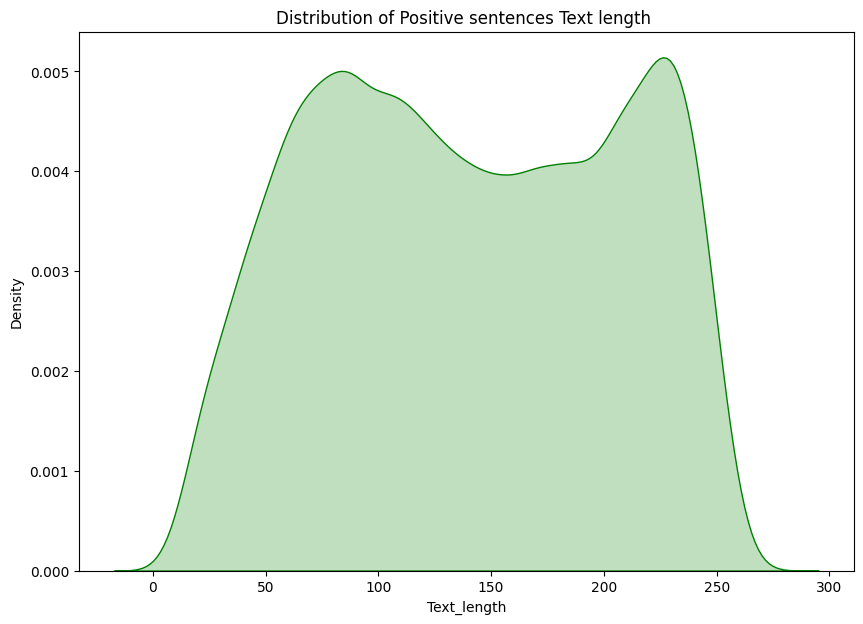

In [21]:
fig = plt.figure(figsize=(10,7))
df['Text_length'] = df['Text_Data'].apply(len)
sns.kdeplot(df[df['Sentiments']==1]['Text_length'],color='green', shade=True)
plt.title("Distribution of Positive sentences Text length ")
plt.show()

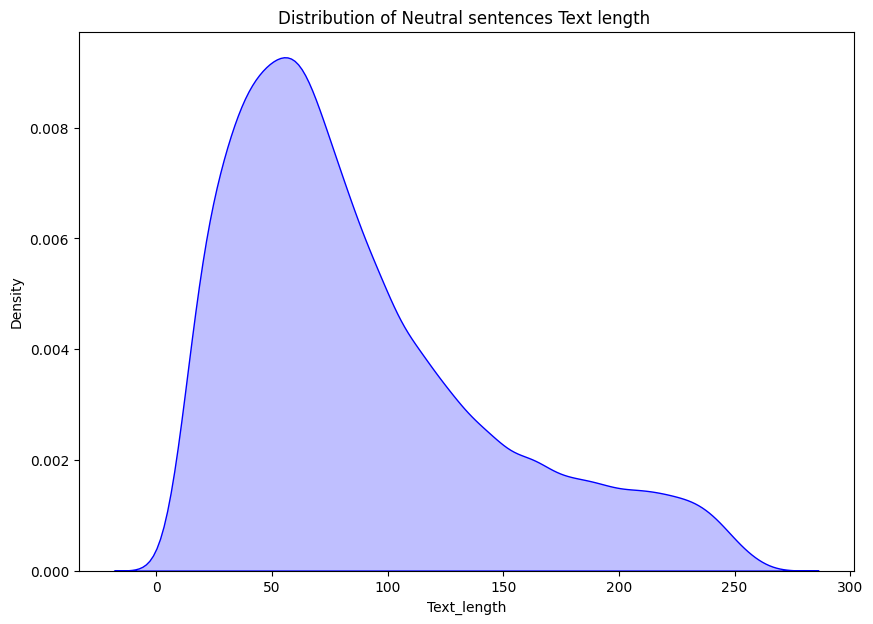

In [22]:
fig = plt.figure(figsize=(10,7))
df['Text_length'] = df['Text_Data'].apply(len)
sns.kdeplot(df[df['Sentiments']==0]['Text_length'],color='blue', shade=True)
plt.title("Distribution of Neutral sentences Text length ")
plt.show()

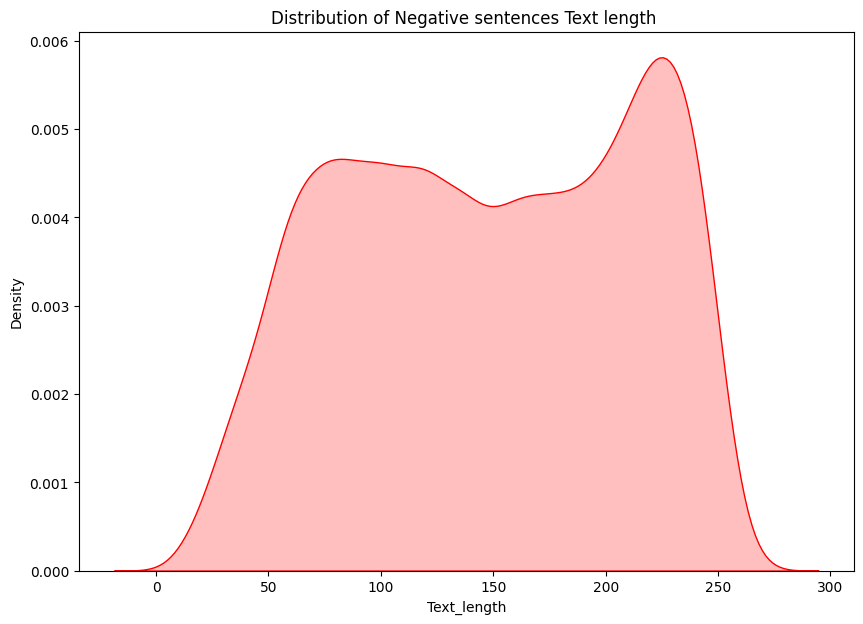

In [23]:
fig = plt.figure(figsize=(10,7))
df['Text_length'] = df['Text_Data'].apply(len)
sns.kdeplot(df[df['Sentiments']==-1]['Text_length'],color='red', shade=True)
plt.title("Distribution of Negative sentences Text length ")
plt.show()

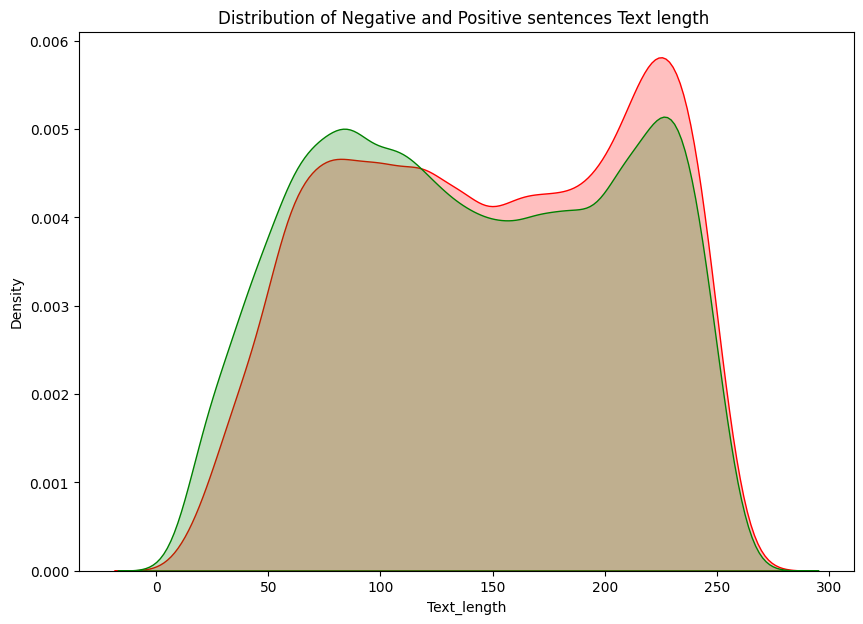

In [24]:
fig = plt.figure(figsize=(10,7))
df['Text_length'] = df['Text_Data'].apply(len)
sns.kdeplot(df[df['Sentiments']==-1]['Text_length'],color='red', shade=True)
sns.kdeplot(df[df['Sentiments']==1]['Text_length'],color='green', shade=True)

plt.title("Distribution of Negative and Positive sentences Text length ")
plt.show()

# Splitting Training and Testing 20% Test Data and 80% Train Data 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [26]:
X_train

['medium guy cant even think straight forward find way criticize modi either soft way hard way ultimate goal hit',
 'namo',
 'add space debris problem aware news risk created indian space agency demonstrating antisatellite capability',
 'today interaction modi phenomenal looking fresh confident ever demolishing opposition clear thought cracking punch stating fact counting achievement really amazing man energy enthusiasm think done',
 'modi bjp want change nitin gadkari fruitful modi',
 'best mam forth coming general election sure time also thumbing victory modi jiabki baat fir modi sarkar keep par vande matram',
 'itna bechain kahe hote chowkidar koi narration nahi change rahachill maro aur may mei modi biopic dekhne plan banao feared anything movie congress well hopefully modi jee loose election',
 'dbt word enough outline intent modi',
 'modi difference even rest follow blindly except thorn wherever rose',
 'illiterate kamaraj change tamil nadu modi also change whole india past year'

In [27]:
y_train

-1.0   0.0   1.0
63425      0     0     1
78455      0     1     0
70129      0     0     1
157073     0     0     1
120885     0     0     1
...      ...   ...   ...
119880     0     1     0
103695     0     1     0
131934     0     0     1
146869     0     0     1
121959     0     0     1

[130375 rows x 3 columns]

In [28]:
y_train[-1.0].value_counts()

0    102018
1     28357
Name: -1.0, dtype: int64

# Tokenizer, Padding

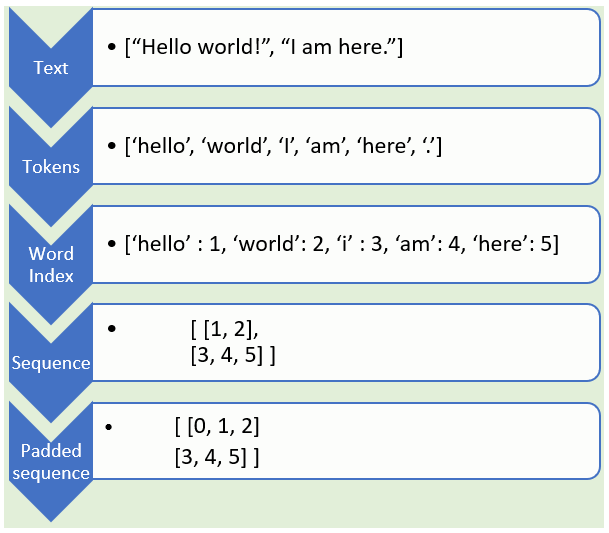

In [29]:
from IPython.display import Image
Image(filename='D:/LSTM Data/pic1.png')


In [30]:
word_tokenizer = Tokenizer(oov_token="<OOV>")
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [31]:
X_train[0]

[72,
 142,
 107,
 24,
 46,
 2262,
 871,
 382,
 92,
 1132,
 2,
 614,
 2744,
 92,
 251,
 92,
 4138,
 1636,
 464]

# Saving my trained TOKENIZER 

In [32]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(word_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [33]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

83209

In [34]:
maxlen = 50

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [35]:
X_train[0]

array([  72,  142,  107,   24,   46, 2262,  871,  382,   92, 1132,    2,
        614, 2744,   92,  251,   92, 4138, 1636,  464,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

# A simple representation of word into its 4 dimension space

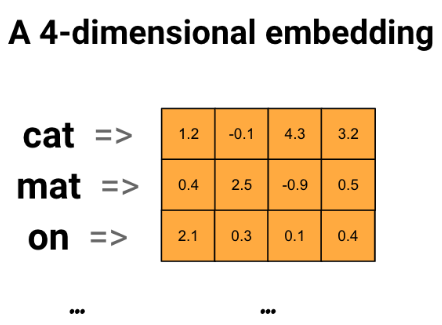

In [36]:
Image(filename='D:/LSTM Data/embedding3.png')

# Preparing  Embedding Layer Using Global Vectors for Word Representation (GLOVE) at 100 Dimension

In [37]:
embedding_dict = dict()

file = open('glove.6B.100d.txt', encoding="utf8")

for lines in file:
    data = lines.split()
    words = data[0]
    words_dimensions = asarray(data[1:], dtype='float32')
    embedding_dict[words] = words_dimensions
file.close()

words_matrix = zeros((vocab_length, 100))
for words, i in word_tokenizer.word_index.items():
    word_vector = embedding_dict.get(words)
    if word_vector is not None:
        words_matrix[i] = word_vector
        
        
        
print(words_matrix.shape)

(83209, 100)


In [38]:
words_matrix[10]

array([-0.40277001,  0.58495998,  0.87568003, -0.56810999, -0.013907  ,
        0.56449997, -0.11333   ,  0.45669001,  0.029677  , -0.091612  ,
       -0.55465001,  0.36219001, -0.26853999, -0.70954001, -0.25184   ,
       -0.34099999,  0.03554   ,  0.3064    ,  0.023176  ,  0.39804   ,
        0.16829   , -0.05377   ,  0.71006   , -0.36818001, -0.28292999,
       -1.12899995,  0.10508   ,  0.12267   ,  0.80870003, -0.48356   ,
        0.91655999,  0.34448001,  0.52961999, -0.064919  ,  0.18566   ,
       -0.35749   ,  0.86166   , -0.33528   , -0.48010001,  0.39552   ,
       -0.82995999, -0.71846002,  0.66178   , -0.57104999, -0.81862998,
       -1.48899996, -0.15516999, -0.96978998, -0.95034999, -1.13929999,
       -0.12744001, -0.079518  ,  0.15376   ,  1.10319996, -0.47755   ,
       -2.19580007,  0.3673    ,  0.023019  ,  1.58109999,  0.12001   ,
       -0.90860999, -0.61724001, -0.01316   ,  0.13869999,  0.79202002,
        0.52389997, -0.34235001,  0.47645   , -0.56497002, -0.41

# Model Building 
## Adding the Glove Embedding layer and Bidirectional LSTM with Dense and Dropout Layers 

In [39]:
embedding_layer = Embedding(vocab_length, 100, weights=[words_matrix],
                            input_length=50 , trainable=False)

In [40]:
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128, dropout = 0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout = 0.3)))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           8320900   
                                                                 
 bidirectional (Bidirectiona  (None, 50, 256)          234496    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

# Training model 

In [41]:
history = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      batch_size = 256, epochs=12, verbose=1)

Epoch 1/12
510/510 [==============================] - 452s 851ms/step - loss: 0.6710 - accuracy: 0.7192 - val_loss: 0.4416 - val_accuracy: 0.8430
Epoch 2/12
510/510 [==============================] - 384s 753ms/step - loss: 0.4705 - accuracy: 0.8297 - val_loss: 0.3781 - val_accuracy: 0.8712
Epoch 3/12
510/510 [==============================] - 367s 720ms/step - loss: 0.4228 - accuracy: 0.8513 - val_loss: 0.3569 - val_accuracy: 0.8820
Epoch 4/12
510/510 [==============================] - 328s 643ms/step - loss: 0.3999 - accuracy: 0.8608 - val_loss: 0.3455 - val_accuracy: 0.8877
Epoch 5/12
510/510 [==============================] - 339s 665ms/step - loss: 0.3847 - accuracy: 0.8674 - val_loss: 0.3298 - val_accuracy: 0.8936
Epoch 6/12
510/510 [==============================] - 340s 666ms/step - loss: 0.3746 - accuracy: 0.8720 - val_loss: 0.3264 - val_accuracy: 0.8940
Epoch 7/12
510/510 [==============================] - 352s 690ms/step - loss: 0.3627 - accuracy: 0.8760 - val_loss: 0.3212 -

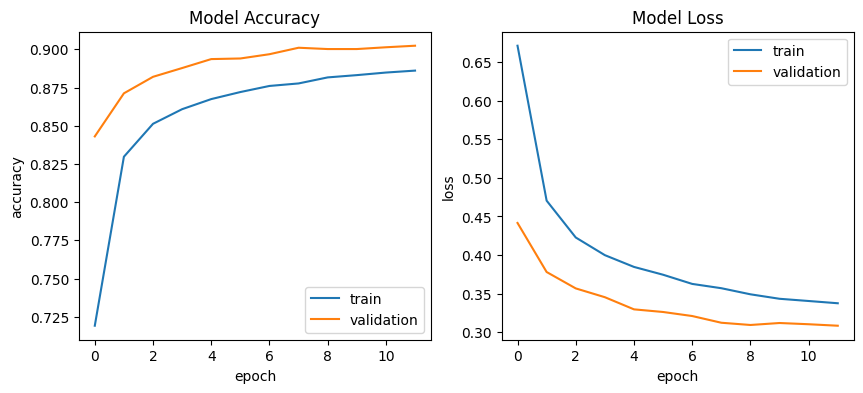

In [42]:
def plot_training_hist(history):
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [43]:
#model.save('lstm_bid_model_90acc.h5')

In [44]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(test_loss)

0.3086164891719818


In [45]:
print(test_accuracy)

0.9023439884185791


# Loading model and start predicting

In [46]:
model = load_model('lstm_bid_model_90acc.h5')

sent = []

def predict(text):
    
    sentiment = ['Negative', 'Neutral', 'Positive']
    max_len = 50
            
    text = word_tokenizer.texts_to_sequences(text)
    text = pad_sequences(text, padding='post', maxlen=max_len)
    
    pred = model.predict(text).argmax(axis=1)
    return(sentiment[pred[0]])


In [47]:
predict(['Hey!! the food was kind of bad at that restaurant'])

1/1 [==============================] - 5s 5s/step


'Negative'

In [48]:
predict(['Alex is pretty good at physics class!'])

1/1 [==============================] - 0s 25ms/step


'Positive'

In [49]:
predict(['there is awful drawing on the awesome blackboard'])

1/1 [==============================] - 0s 26ms/step


'Negative'

In [50]:
predict(['we want to predict this sentence sentiment what it should be?'])

1/1 [==============================] - 0s 53ms/step


'Neutral'

In [51]:
predict(['Today weather is worst, yesterday weather was amazing']) 

1/1 [==============================] - 0s 25ms/step


'Negative'

# CLASSIFICATION REPORT

In [52]:
y_pred = model.predict(X_test)
classification_report = classification_report(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
print(classification_report)

1019/1019 [==============================] - 27s 27ms/step
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      7152
           1       0.90      0.95      0.92     11067
           2       0.93      0.90      0.91     14375

    accuracy                           0.90     32594
   macro avg       0.90      0.90      0.90     32594
weighted avg       0.90      0.90      0.90     32594



# CONFUSION MATRIX

1019/1019 [==============================] - 27s 27ms/step


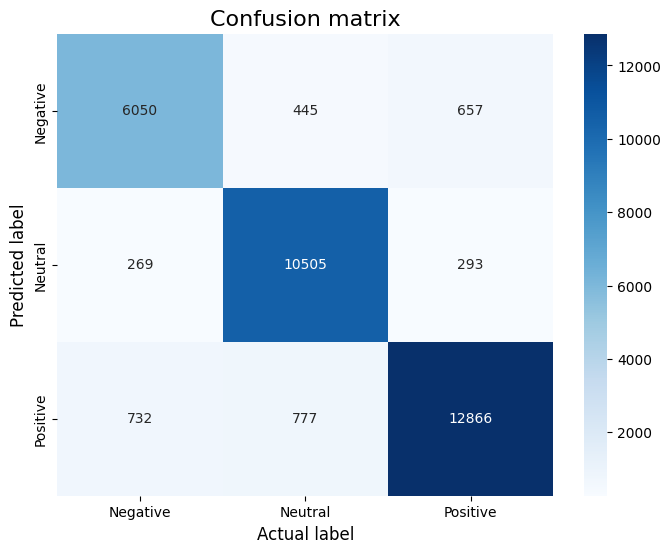

In [53]:

def plot_confusion_matrix(model, X_test, y_test):
    
    sentiment = ['Negative', 'Neutral', 'Positive']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment,
                yticklabels=sentiment)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

# BERT Model

In [54]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [55]:
# From HuggingFace

Bert_tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
Bert_model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [56]:
tokens = Bert_tokenizer.encode('I did learned so many things from this class because the professor was amazing', return_tensors='pt')
tokens

tensor([[  101,   151, 12266, 35052, 10297, 11260, 17994, 10195, 10372, 12728,
         12175, 10103, 12156, 10140, 39854,   102]])

In [57]:
prediction_results = Bert_model(tokens)
prediction_results

SequenceClassifierOutput(loss=None, logits=tensor([[-1.4081, -1.1411, -0.1829,  0.8283,  1.4013]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [58]:
sentiment_classes = ['Completely Negative','SomeWhat Negative','Neutral','SomeWhat Positive', 'Positive']

In [59]:
print('The predicted sentiment is', sentiment_classes[int(prediction_results.logits[0].argmax())])

The predicted sentiment is Positive


# IMDB WEB SCRAPPING

### Avengers Endgame

In [60]:
r = requests.get('https://www.imdb.com/title/tt4154796/reviews?ref_=tt_urv')
soup = BeautifulSoup(r.text, 'html.parser')
regex = re.compile('.*text show-more__control.*')
results = soup.find_all('div', {'class':regex})
reviews = [result.text for result in results]
reviews

["But its a pretty good film. A bit of a mess in some parts, lacking the cohesive and effortless feel infinity war somehow managed to accomplish. Some silly plot holes and characters that could've been cut (Ahem, captain marvel and thanos). The use of Captain marvel in this film was just ridiculous. Shes there at the start, bails for some reason? And then pops up at the end to serve no purpose but deux ex machina a space ship...The past thanos part wasn't necessary when you think about it, they could've done this film without a real 'villain' And it would've worked and been a original take on a super hero film without using the same formula we have seen in 10+ super hero films already. The entire final battle felt like a rehashed messy battle, with a bunch more characters against thanos - basically mixing the space battle from infinity war; iron man, spider man etc and the final battle of infinity war with captain america, thor etc.. mashing those two into one within this new film. The

In [61]:
df = pd.DataFrame(np.array(reviews), columns=['review'])
df

review
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [62]:
def bertmodelpred(text):
    tokened = Bert_tokenizer.encode(text, return_tensors='pt')
    pred = Bert_model(tokened)
    return(sentiment_classes[int(pred.logits[0].argmax())])

In [63]:
df['BERTModelPred'] = df['review'].apply(lambda y: bertmodelpred(y[:512])) 

In [64]:
df['MyModelPred'] = df['review'].apply(lambda x: predict([x[:50]]) ) 

1/1 [==============================] - 0s 26ms/step


In [65]:
df

review  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [66]:
import mitosheet
mitosheet.sheet(df, analysis_to_replay="id-oyrqwndxif")

In [67]:
predict(['there is a very awful drawing on the awesome blackboard'])

1/1 [==============================] - 0s 60ms/step


'Negative'

In [68]:
bertmodelpred('there is a very awful drawing on the awesome blackboard')

'Completely Negative'